# $CatBoost\ Tuning$
---
Experimenting on model hyperparameter tuning for catboost-based regressor

In [ ]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [47]:
# Basic 
import sys
import json

# Warning problems in notebook
import warnings
warnings.filterwarnings('ignore')

# Profiling process
from tqdm import tqdm

# Reporting result
from IPython.display import display

# Math
import numpy as np
import scipy as sp
import pandas as pd
from numpy import log10, log

# Statistics
from statsmodels.stats.outliers_influence import variance_inflation_factor

# SQL Engine
import psycopg2
import pandas as pd
from sqlalchemy import create_engine

# Visualization
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

# Reporting result
import sweetviz as sv
from dataprep.eda import create_report, plot, plot_missing, plot_correlation

# Metrics
from sklearn import metrics

# Learning Helper | Modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LinearRegression, PoissonRegressor, RANSACRegressor

# CLustering
from sklearn.cluster import KMeans

from catboost import CatBoostRegressor, Pool

# Dimension reductionality
from sklearn.decomposition import PCA

In [48]:
# Progress apply for pandas
tqdm.pandas()

# Seaborn color palette
sns.set_palette('husl')

# Inline matplotlib
%matplotlib inline

# Plotting pretty figures and avoid blurry images
%config InlineBackend.figure_format = 'retina'

# Larger scale for plots in notebooks
sns.set_context('notebook')

In [49]:
# Saving model 
def save_model(model, name="model"):
    pickle.dump(model, open(f"../bin/{name}", "wb"))
    
# Load Model
def load_model(filename):
    with open(filename, 'rb') as f:
        model = pickle.load(f)
    return model

In [50]:
def evaluate_model(true, predicted):  
    rmsle = metrics.mean_squared_log_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2 = metrics.r2_score(true, predicted)
    print('RMSLE:',rmsle)
    print('RMSE:', rmse)
    print("R2:", r2)
    print('__________________________________')
    return rmsle, rmse, r2 

## $Data\ Preparation$

**Data Loading**

In [51]:
# === Load data ===
## EDIT THIS CODE
# =====================
filename = "../data/processed/dataset-supervised-processed.pkl"
# =====================

target = "wd_actual_delivery_interval"

df = pd.read_pickle(filename)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90183 entries, 0 to 95126
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   total_unique_item                90183 non-null  int64  
 1   product_volume_cm3_per_item      90183 non-null  float64
 2   product_weight_g_per_item        90183 non-null  float64
 3   order_day_of_week                90183 non-null  int64  
 4   order_day_of_month               90183 non-null  int64  
 5   order_quarter                    90183 non-null  float64
 6   order_is_weekend                 90183 non-null  bool   
 7   order_hour                       90183 non-null  int64  
 8   order_daytime                    90183 non-null  object 
 9   order_approved_day_of_week       90183 non-null  float64
 10  order_approved_day_of_month      90183 non-null  float64
 11  order_approved_quarter           90183 non-null  float64
 12  order_approved_is_

**Feature Preparation**

In [52]:
cat_num_features =['order_quarter', 'order_is_weekend',
                               'order_approved_quarter', 'order_approved_is_weekend',
                               'pickup_limit_quarter', 'pickup_limit_is_weekend', "is_same_area"]
cat_str_features = ["order_daytime", "order_approved_daytime"]

for col in tqdm(cat_num_features):
    df[col] = df[col].astype(int)

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 259.96it/s]


**Data Splitting**
- Train size : 80%
- Val size : 20%

In [53]:
target = "wd_actual_delivery_interval"
X = df.drop([target] + ["wd_estimated_delivery_interval"], axis = 1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.2)

train = X_train.copy()
train[target] = y_train.values
val = X_test.copy()
val[target] = y_test.values

## $ CatBoost\ Implementation$
---
**Feature used:**
- Custom loss function -> asymetric mse
- Custom metric func -> RMSLE (custom made)
- Using best model
- Early stopping
- Snapshot save
- Feature Importance
- Saving model

In [54]:
# === Normal Implementation (No Tuning) ===
import pickle
model_file = "../bin/catboost-regressor"
model = load_model(model_file)

**Custom Loss Function**

In [57]:
class AsymetricMSEObjective(object):
    """
    Penalize 10 time more for late than not late
    """
    def calc_ders_range(self, approxes, targets, weights):
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)
        
        result = []
        residual = (targets - approxes).astype('float') 
        der1_all = np.where(residual < 0, -2.0 * 10.0 * residual, -2.0 * residual).astype('float')
        der2_all = np.where(residual < 0, 2.0 * 10.0, 2.0).astype('float')
        for index in range(len(targets)):
            der1 = der1_all[index]
            der2 = der2_all[index]
            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]
            result.append((der1, der2))
        return result

**Custom Metric Function**

In [58]:
class RMSLEMetric(object):
    def is_max_optimal(self):
        # Returns whether great values of metric are better
        return False

    def evaluate(self, approxes, target, weight):     
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])
        
        approx = approxes[0]
        
        error_sum = 0.0
        weight_sum = 0.0
        
        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            error_sum += w * ((log(approx[i] + 1) - log(target[i] + 1)) ** 2)

        return error_sum, weight_sum
        
    
    def get_final_error(self, error, weight):
        # Returns final value of metric based on error and weight
        return np.sqrt(error / (weight + 1e-38))

In [63]:
from catboost.metrics import RMSE
# == Custom implementation (with custom loss func & metric) ==
param = {
    'eval_metric': RMSLEMetric(),
    'custom_loss' : [AsymetricMSEObjective(), RMSE()],
    'use_best_model': True,
    'verbose': 20,
    'iterations' : 5000,
    'random_state' : 123,
    'early_stopping_rounds' : 100,
    'cat_features' :cat_num_features + cat_str_features
}
    
model = CatBoostRegressor(**param)

**Training**

In [64]:
model.fit(
    X_train, 
    y_train, 
    eval_set = (X_test, y_test), 
    use_best_model = True,
    save_snapshot=True
)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 2.0925789	test: 2.1023760	best: 2.1023760 (0)	total: 1.44s	remaining: 23m 59s
10:	learn: 1.0961110	test: 1.1041045	best: 1.1041045 (10)	total: 11.5s	remaining: 17m 17s
20:	learn: 0.8232653	test: 0.8301243	best: 0.8301243 (20)	total: 21.6s	remaining: 16m 45s
30:	learn: 0.7073899	test: 0.7138008	best: 0.7138008 (30)	total: 37.4s	remaining: 19m 30s
40:	learn: 0.6475730	test: 0.6535797	best: 0.6535797 (40)	total: 49.8s	remaining: 19m 25s
50:	learn: 0.6119876	test: 0.6177002	best: 0.6177002 (50)	total: 1m 5s	remaining: 20m 19s
60:	learn: 0.5896090	test: 0.5951521	best: 0.5951521 (60)	total: 1m 16s	remaining: 19m 31s
70:	learn: 0.5737281	test: 0.5790707	best: 0.5790707 (70)	total: 1m 26s	remaining: 18m 52s
80:	learn: 0.5628815	test: 0.5681731	best: 0.5681731 (80)	total: 1m 38s	remaining: 18m 36s
90:	learn: 0.5544436	test: 0.5597473	best: 0.5597473 (90)	total: 1m 50s	remaining: 18m 19s
100:	learn: 0.5484654	test: 0.5538556	best: 0.5538556 (100)	total: 2m 6s	remaining: 18m 41s
110:	l

**Saving Model**

In [65]:
# === Saving Script ===
model.save_model('catboost-regressor-custom.dump')

# === Load Script ===
# model.load_model('catboost-regressor-custom.dump')

**Applying Result**

In [71]:
pred = model.predict(X_test)
pred = np.where(pred < 0, 0, pred)
rmsle, rmse, r2 = evaluate_model(y_test, pred)

RMSLE: 0.2611031111221788
RMSE: 6.064751425284389
R2: -0.00933042696726849
__________________________________


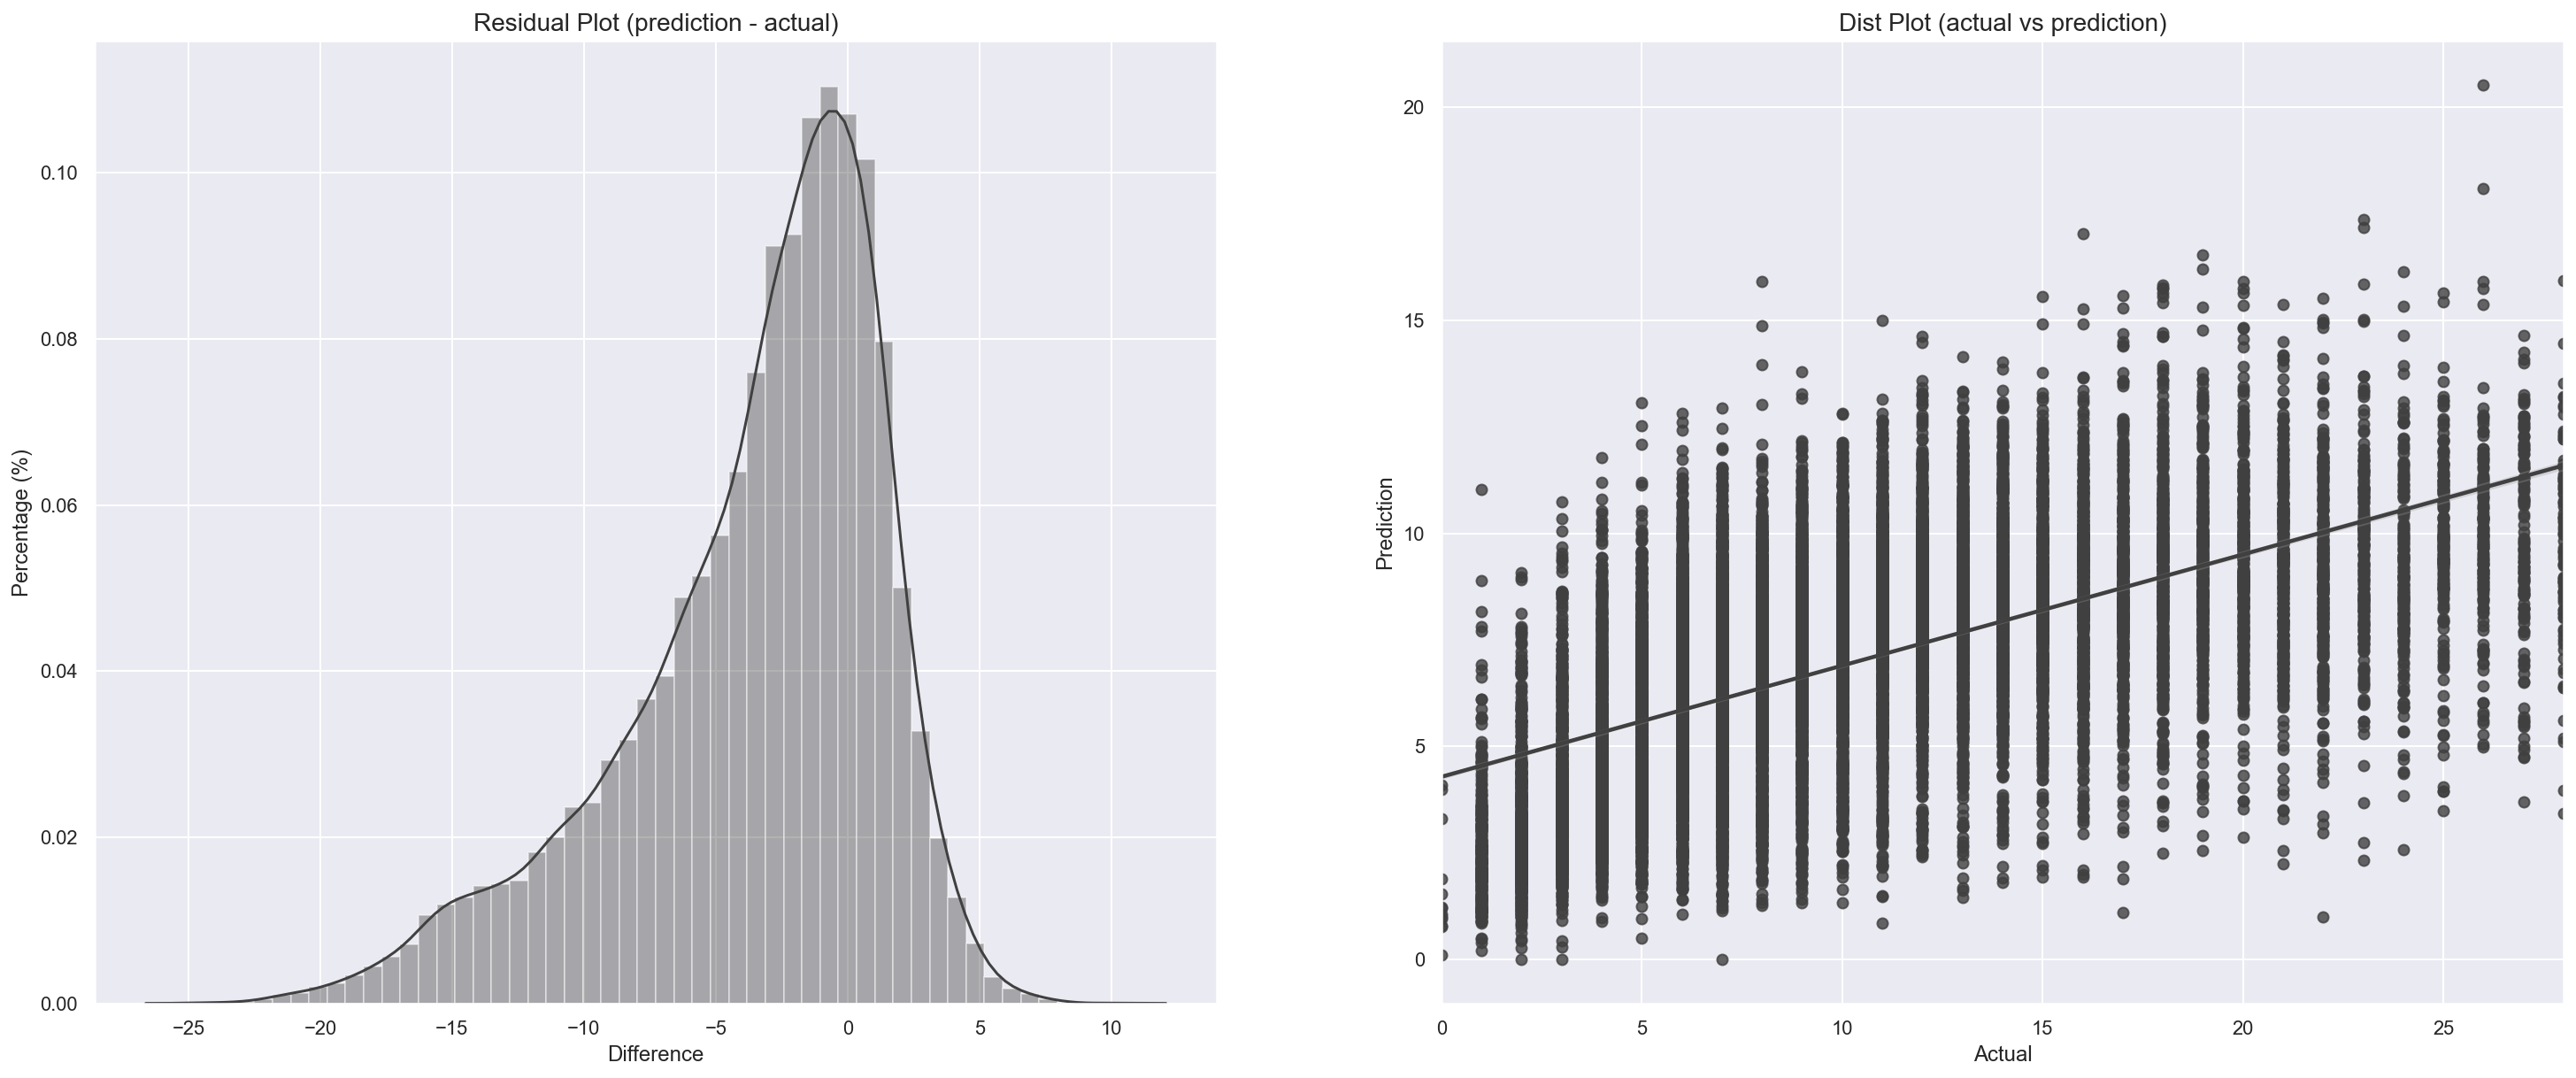

In [89]:
# === Plot the Residual Plot & Distribution plot ===
plt.figure(figsize=(25,10))

score_df = pd.DataFrame({
    'actual': y_test,
    'prediction' : pred
})

plt.subplot(1,2,1)
plt.title("Residual Plot (prediction - actual)", fontsize = 14)
a = sns.distplot(score_df['prediction'] - score_df["actual"], color = "0.25")
a.set_xlabel("Difference",fontsize=12)
a.set_ylabel("Percentage (%)",fontsize=12)
plt.plot()

plt.subplot(1,2,2)
plt.title("Dist Plot (actual vs prediction)", fontsize = 14)
g = sns.regplot('actual', 'prediction', data=score_df, color='0.25')
g.set_xlabel("Actual",fontsize=12)
g.set_ylabel("Prediction",fontsize=12)
plt.plot()

plt.show()

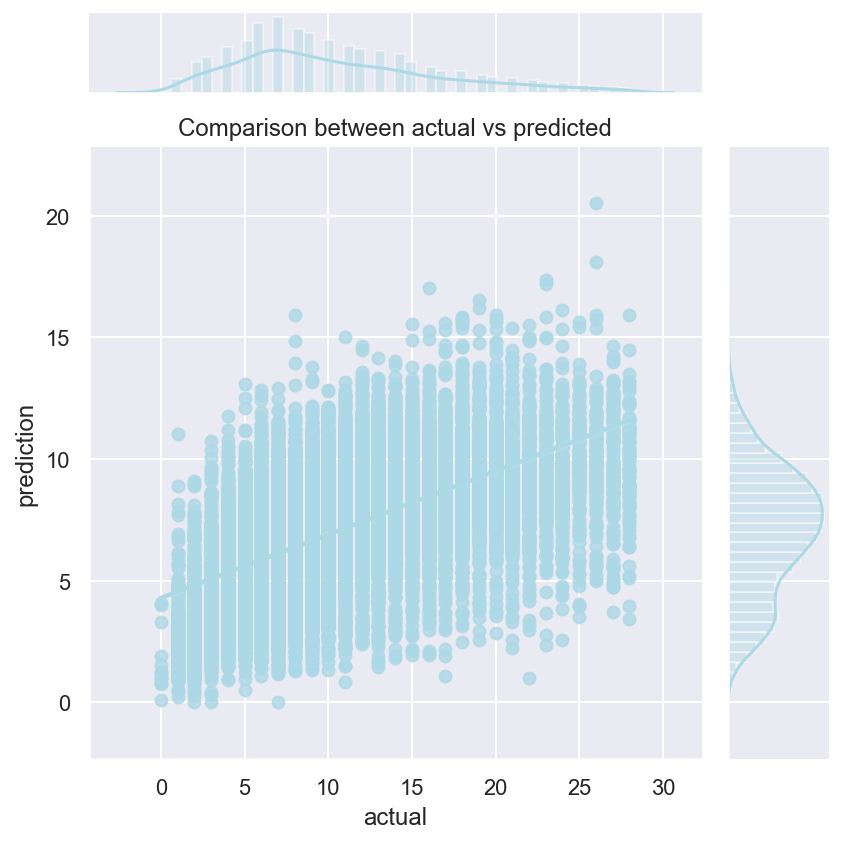

In [88]:
# === Plot the Distribution Plot ===
score_df = pd.DataFrame({
    'actual': y_test,
    'prediction' : pred
})

sns.set({'figure.figsize':(7,7)})
g = sns.jointplot('actual', 'prediction', data=score_df,kind='reg', color='lightblue', space=0)
plt.title("Comparison between actual vs predicted")
plt.tight_layout()
plt.show()

## $Hyperparameter\ Tuning$
---
Using **hyperopt** for hyperparameter tuning

**Hyperparameter** to tune (range):
- learning rate : 0.05, 0.1
- depth : 3, 5, 7
- l2_leaf_reg : 1, 3, 5, 7

In [99]:
import hyperopt

def hyperopt_objective(params):
    
    param = {
        'eval_metric': RMSLEMetric(),
        'loss_function' : AsymetricMSEObjective(),
        'learning_rate' : params['learning_rate'],
        'depth':int(params['depth']),
        'l2_leaf_reg':params['l2_leaf_reg'],
        'use_best_model': True,
        'verbose': False,
        'iterations' : 5000,
        'random_state' : 123,
        'early_stopping_rounds' : 200,
        'cat_features' :cat_num_features + cat_str_features
    }
    
    tuned_model = CatBoostRegressor(**param)
    tuned_model.fit(
        X_train, 
        y_train, 
        eval_set = (X_test, y_test), 
        use_best_model = True
    )
    
    nb_trees = tuned_model.tree_count_
    
    pred = tuned_model.predict(X_test)
    pred = np.where(pred < 0, 0, pred)
    rmsle, rmse, r2 = evaluate_model(y_test, pred)
    
    return rmsle # as hyperopt minimises

In [100]:
from numpy.random import RandomState

params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 3, 8, 2),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
    'depth': hyperopt.hp.quniform('depth', 3, 7, 2),
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=RandomState(123)
)

print(best)

  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

build_posterior_wrapper took 0.002229 seconds
TPE using 0 trials
Custom logger is already specified. Specify more than one logger at same time is not thread safe.job exception: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/python-package/catboost/helpers.cpp:42: Traceback (most recent call last):
  File "_catboost.pyx", line 1315, in _catboost._MetricEval
  File "<ipython-input-58-f44884ded8f7>", line 18, in evaluate
    error_sum += w * ((log(approx[i] + 1) - log(target[i] + 1)) ** 2)
KeyboardInterrupt



  0%|                                                                           | 0/50 [01:21<?, ?trial/s, best loss=?]


CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/python-package/catboost/helpers.cpp:42: Traceback (most recent call last):
  File "_catboost.pyx", line 1315, in _catboost._MetricEval
  File "<ipython-input-58-f44884ded8f7>", line 18, in evaluate
    error_sum += w * ((log(approx[i] + 1) - log(target[i] + 1)) ** 2)
KeyboardInterrupt


In [ ]:
tuned_param = {
    'l2_leaf_reg' : int(best['l2_leaf_reg']),
    'learning_rate' : int(best['learning_rate']),
    'depth' : int(best['depth']),
    'eval_metric': RMSLEMetric(),
    'loss_function' : AsymetricMSEObjective(),
    'use_best_model': True,
    'verbose': 50,
    'iterations' : 5000,
    'random_state' : 123,
    'early_stopping_rounds' : 200,
    'cat_features' :cat_num_features + cat_str_features
}

tuned_model = CatBoostRegressor(**tuned_param)
tuned_model.fit(
    X_train, 
    y_train, 
    eval_set = (X_test, y_test), 
    use_best_model = True
)

In [11]:
# === Plot result ===
pred = model.predict(X_test)
pred = np.where(pred < 0, 0, pred)
rmsle, rmse, r2 = evaluate_model(y_test, pred)

In [ ]:
# === Plot the Residual Plot & Distribution plot ===
plt.figure(figsize=(25,10))

score_df = pd.DataFrame({
    'actual': y_test,
    'prediction' : pred
})

plt.subplot(1,2,1)
plt.title("Residual Plot (prediction - actual)", fontsize = 14)
a = sns.distplot(score_df['prediction'] - score_df["actual"], color = "0.25")
a.set_xlabel("Difference",fontsize=12)
a.set_ylabel("Percentage (%)",fontsize=12)
plt.plot()

plt.subplot(1,2,2)
plt.title("Dist Plot (actual vs prediction)", fontsize = 14)
g = sns.regplot('actual', 'prediction', data=score_df, color='0.25')
g.set_xlabel("Actual",fontsize=12)
g.set_ylabel("Prediction",fontsize=12)
plt.plot()

plt.show()

In [ ]:
# === Plot the Distribution Plot ===
score_df = pd.DataFrame({
    'actual': y_test,
    'prediction' : pred
})

sns.set({'figure.figsize':(7,7)})
g = sns.jointplot('actual', 'prediction', data=score_df,kind='reg', color='lightblue', space=0)
plt.title("Comparison between actual vs predicted")
plt.tight_layout()
plt.show()

In [ ]:
# == Save Model ==
tuned_model.save_model('catboost-regressor-custom-tuned.dump')

**End**

[Reference (Tuning Catboost)](https://colab.research.google.com/github/catboost/tutorials/blob/master/python_tutorial.ipynb#scrollTo=GqQXWo6Ix1Jf)

**Cross Validation**

In [67]:
from catboost import cv
cv_params = model.get_params()
cv_params.update({
    'logging_level': 'Silent'
})
cv_data = cv(
    Pool(X, y, cat_features=cat_num_features + cat_str_features),
    cv_params,
    fold_count=5,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.0944237	test: 2.0944735	best: 2.0944735 (0)	total: 6.02s	remaining: 1h 40m 17s
10:	learn: 1.0962228	test: 1.0964059	best: 1.0964059 (10)	total: 1m 3s	remaining: 1h 35m 22s


CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/python-package/catboost/helpers.cpp:42: Traceback (most recent call last):
  File "_catboost.pyx", line 1315, in _catboost._MetricEval
  File "<ipython-input-58-f44884ded8f7>", line 18, in evaluate
    error_sum += w * ((log(approx[i] + 1) - log(target[i] + 1)) ** 2)
KeyboardInterrupt


In [ ]:
print('Best validation rmsle score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-Accuracy-mean']),
    cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
    np.argmax(cv_data['test-Accuracy-mean'])
))

In [ ]:
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

In [ ]:
# === Feature Selection ===
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm

param = {
    'eval_metric': 'RMSE',
    'objective' : 'RMSE',
    'use_best_model': True,
    'silent':True,
    'random_state' : 123,
    'early_stopping_rounds' : 10,
    'cat_features' :cat_num_features + cat_str_features
}
    
model = CatBoostRegressor(**param)

summary = model.select_features(
    X_train, y_train,
    eval_set=(X_test, y_test),
    features_for_select=list(X_train.columns),
    num_features_to_select=25,
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
)

In [ ]:
print("=== Feature Selection Result ===")

print("=== Selected Feature (15) ===")
for item in summary['selected_features_names']:
    print(item)
print("=== Removed Feature ===")
for item in summary['eliminated_features_names']:
    print(item)
    
X_train = X_train[summary['selected_features_names']]
X_test = X_test[summary['selected_features_names']]

In [ ]:
cat_features = list(set(cat_num_features + cat_str_features) - set(summary['eliminated_features_names']))
param = {
    'eval_metric': 'RMSE',
    'objective' : 'RMSE',
    'verbose' : 200,
    'iterations' : 50000,
    'random_state' : 123,
    'early_stopping_rounds' : 100,
    'cat_features' :cat_features
}

fs_model = CatBoostRegressor(**param)
fs_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model = True)

In [35]:
# === Show cross val result ===

kf = KFold(n_splits=5, shuffle=True, random_state=123)
scores_rmse = []
scores_rmsle = []
scores_r2 = []
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
for idx, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"=== Fold {idx+1} ===")
    X_train_fold, X_test_fold = X.loc[train_index], X.loc[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    X_train_fold = X_train_fold[summary['selected_features_names']]
    X_test_fold = X_test_fold[summary['selected_features_names']]
    
    pred_fold = fs_model.predict(X_test_fold)
    pred_fold = list(map(lambda val : 0 if val < 0 else val, pred_fold))
    rmsle, rmse, r2  = evaluate_model(y_test_fold,pred_fold)
    
    scores_rmse.append(rmse)
    scores_rmsle.append(rmsle)
    scores_r2.append(r2)
print("RMSLE score :", np.mean(scores_rmsle))

=== Fold 1 ===
RMSLE: 0.17965556662898394
RMSE: 4.659889577348253
R2: 0.4041202782663682
__________________________________
=== Fold 2 ===
RMSLE: 0.15389071284716285
RMSE: 4.196052651589361
R2: 0.5177920331208172
__________________________________
=== Fold 3 ===
RMSLE: 0.15164033192873033
RMSE: 4.2327924824409155
R2: 0.5107119144748435
__________________________________
=== Fold 4 ===
RMSLE: 0.15092086028902493
RMSE: 4.213339763489355
R2: 0.5154311848006663
__________________________________
=== Fold 5 ===
RMSLE: 0.1505867709772765
RMSE: 4.203426090277126
R2: 0.5154648705132074
__________________________________
RMSLE score : 0.1573388485342357


In [36]:
save_model(summary, "catboost-feature-selection-summary")
save_model(fs_model, "catboost-regressor-fs")

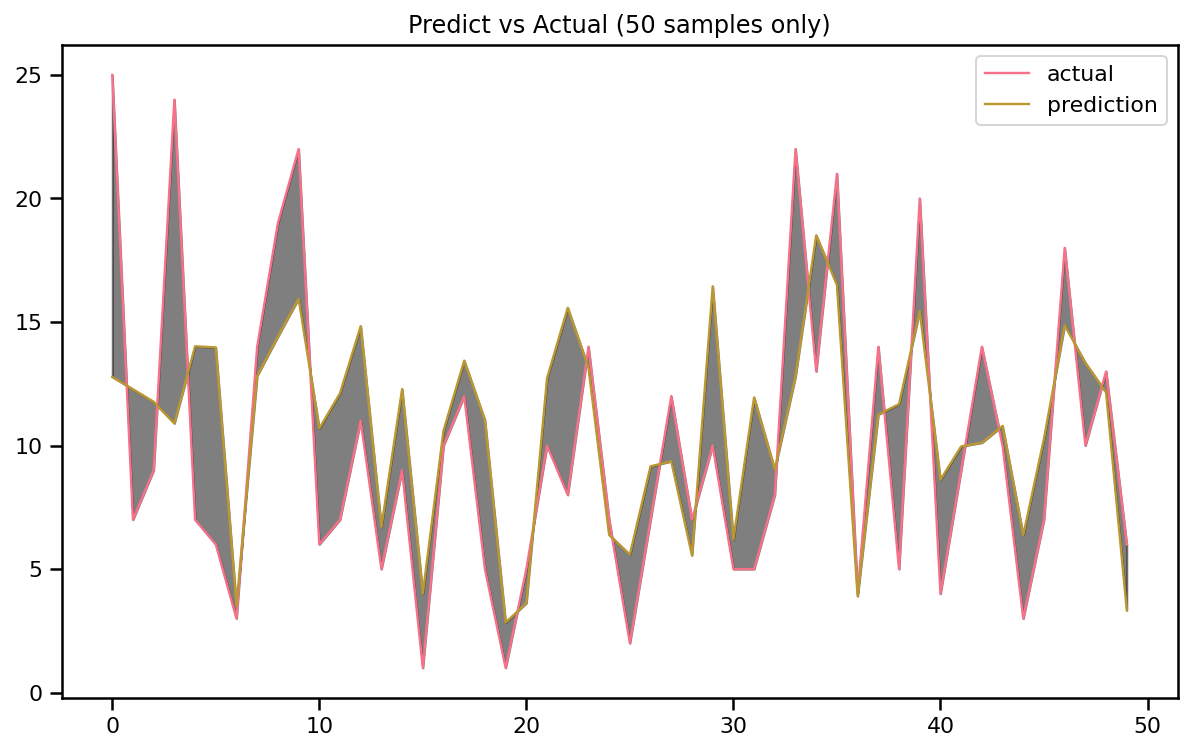

In [60]:
# === Evaluation ===
pred = fs_model.predict(X_test)
pred = list(map(lambda val : 0 if val < 0 else val, pred))
x = range(len(pred[:50]))
y1 = y_test[:50]
y2 = pred[:50]

plt.figure(figsize=(10,6))
plt.plot(x,y1,lw=1.2, label='actual')
plt.plot(x,y2,lw=1.2, label='prediction')
plt.fill_between(x, y1,y2,color='k',alpha=.5)
plt.legend()
plt.title("Predict vs Actual (50 samples only)")
plt.show()

In [ ]:
# === Create a cross validation scoring ===
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=123)
scores_rmse = []
scores_rmsle = []
scores_r2 = []
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
for idx, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"=== Fold {idx+1} ===")
    X_train_fold, X_test_fold = X.loc[train_index], X.loc[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    pred_fold = model.predict(X_test_fold)
    rmsle, rmse, r2  = evaluate_model(y_test_fold,pred_fold)
    
    scores_rmse.append(rmse)
    scores_rmsle.append(rmsle)
    scores_r2.append(r2)
print("RMSLE score :", np.mean(scores_rmsle))